In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
import cv2 as cv
import os
%matplotlib inline

import pickle

In [2]:
def convpool(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

In [3]:
def charge_dataset(ruta):
    File = open(ruta, 'rb')
    data_x_tmp = pickle.load(File)
    data_y = pickle.load(File)
    File.close()
    del(File)
    return data_x_tmp, data_y

def show_img(data_x_tmp, data_y, index_img=255):   
    plt.imshow(data_x_tmp[index_img])
    if data_y[index_img, 0]:
        print (">>> La imagen No. {} está etiquetado como Hombre.".format(index_img))
    else:
        print (">>> La imagen No. {} está etiquetado como Mujer".format(index_img))

def get_new_colmns(data_x_tmp):
    new_colmns = 1
    for i in range(3):
        new_colmns *= data_x_tmp.shape[i+1]
    return new_colmns

def  x_reshape_and_normalize(data_x_tmp):
    rows = data_x_tmp.shape[0]
    new_colmns = get_new_colmns(data_x_tmp)
    data_x = data_x_tmp.reshape((rows,new_colmns))
    colmns = data_x.shape[1]
    print("Nuevas dimensiónes de X {}".format(data_x.shape))
    print('\n>>> Datos de X sin normalizar: \r\n {}\n'.format(data_x))
    # Normalizamos los datos.
    data_x = data_x/255 
    print('>>> Datos de X normalizados: \r\n {}\n'.format(data_x))
    return data_x, rows, colmns

In [4]:
# Obtencion y normalizacion de datos
ruta = ('dataset/data.pckl')
index_img = 14000  ### Se puede cambiar el indice (0-258)
def dataset_init(ruta, index_img):
    data_x_tmp, data_y = charge_dataset(ruta)
    print("Dimensión de X {}".format(data_x_tmp.shape))
    print("Dimensión de Y {}".format(data_y.shape))
    show_img(data_x_tmp, data_y, index_img)
    data_x, rows, colmns = x_reshape_and_normalize(data_x_tmp)
    return data_x, data_y, rows, colmns

Dimensión de X (24032, 64, 64, 3)
Dimensión de Y (24032, 1)
>>> La imagen No. 14000 está etiquetado como Hombre.
Nuevas dimensiónes de X (24032, 12288)

>>> Datos de X sin normalizar: 
 [[ 25  21  18 ...  61  65  45]
 [241 240 232 ... 222 228 233]
 [ 87  97  73 ...  65  65  40]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

>>> Datos de X normalizados: 
 [[0.09803922 0.08235294 0.07058824 ... 0.23921569 0.25490196 0.17647059]
 [0.94509804 0.94117647 0.90980392 ... 0.87058824 0.89411765 0.91372549]
 [0.34117647 0.38039216 0.28627451 ... 0.25490196 0.25490196 0.15686275]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00784314 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]



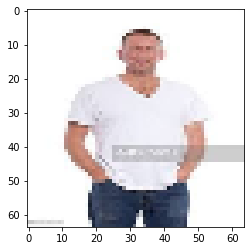

In [5]:
# Obtengo mis datos
data_x, data_y_tmp, rows, colmns = dataset_init(ruta, index_img)

In [6]:
oneHot = OneHotEncoder()
oneHot.fit(data_y_tmp)
data_y = oneHot.transform(data_y_tmp).toarray()

C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
print(data_y[index_img,:])

[0. 1.]


In [8]:
X_train, X_tmp, Y_train, Y_tmp = tts(data_x, data_y, test_size=0.2, random_state=None) 
X_test, X_validation, Y_test, Y_validation = tts(X_tmp, Y_tmp, test_size=0.5, random_state=None) 
X_train = np.array(X_train)
X_validation = np.array(X_validation)
X_test = np.array(X_test)
print('Train:{}, Validation:{}, Test {}'.format(X_train.shape,X_validation.shape,X_test.shape))
print(type(Y_train))
print(Y_train.shape)

Train:(19225, 12288), Validation:(2404, 12288), Test (2403, 12288)
<class 'numpy.ndarray'>
(19225, 2)


In [9]:
ruta = 'dataset/test_data.pckl'
File = open(ruta, 'wb')
pickle.dump(X_test,File) 
pickle.dump(Y_test,File)
File.close()
del(File)

In [10]:
samples = np.shape(X_train)[0]
learning_rate = 0.0009
num_epochs = 50
display_step = 1
hidden_layer_size = 300          # Número de neuronas en capa oculta
n = np.shape(X_train)[1]         # Número de cararcteristicas
n_class = np.shape(Y_train)[1]   # Número de clases
#batch_sz = int(samples*0.1)
batch_sz = 2404
n_batches = int(samples/batch_sz)
batch_sz 

2404

In [11]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [batch_sz, 64, 64, 3])
Y = tf.placeholder(tf.float32, [batch_sz, n_class])

In [12]:
W1 = tf.get_variable("W1", [8, 8, 3, 32])
b1 = tf.get_variable("b1", 32)
W2 = tf.get_variable("W2",[8, 8, 32, 64])
b2 = tf.get_variable("b2", 64)
W3 = tf.get_variable("W3",[16*16*64, hidden_layer_size])
b3 = tf.get_variable("b3",[hidden_layer_size])
W4 = tf.get_variable("W4",[hidden_layer_size, n_class])
b4 = tf.get_variable("b4",n_class)

W1116 17:38:01.120532  9996 deprecation.py:506] From C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Z = tf.matmul(Z3, W4) + b4
y_ = tf.nn.tanh(Z)
prediccion = tf.equal(tf.argmax(y_, 1), tf.argmax(Y, 1))

In [14]:
J = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Z)
mean_J = tf.reduce_mean(J)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(mean_J)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_J)

accuracy = tf.reduce_mean(tf.cast(prediccion, tf.float32))
saver = tf.train.Saver()

In [15]:
X.shape

TensorShape([Dimension(2404), Dimension(64), Dimension(64), Dimension(3)])

In [16]:
train_cost = []
validation_cost = []
prev_validation_accuracy = 0
with tf.name_scope("starting_tensorflow_session"):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        cont = 0
        for epoch in range(num_epochs):
            for batch in range(n_batches):
                X_batch = X_train[batch*batch_sz:(batch*batch_sz + batch_sz),:]
                Y_batch = Y_train[batch*batch_sz:(batch*batch_sz + batch_sz),:]
                X_batch = X_batch.reshape(X_batch.shape[0], 64, 64, 3)
                #print(X_batch.shape)
                _, t_cost = sess.run([optimizer, mean_J], feed_dict={X: X_batch, Y: Y_batch})
                train_cost.append(t_cost)
  
            X_validation = X_validation.reshape(X_validation.shape[0], 64, 64, 3)   
            v_cost, v_accuracy = sess.run([mean_J, accuracy], 
                                        feed_dict={X: X_validation, Y: Y_validation})
            validation_cost.append(v_cost)
            if (epoch+1) % display_step == 0:
                print("Epoch: {}".format(epoch + 1), "train_cost={:0.4f}".format(t_cost), 
                      "validation_cost={:0.4f}".format(v_cost), "validation_accuracy={:0.2f}".format(v_accuracy*100))
            if v_accuracy <= prev_validation_accuracy:
                cont = cont+1;
            else:
                cont = 0
            if cont > 2:
                break
            prev_validation_accuracy = v_accuracy
            saver.save(sess, os.getcwd()+"/modeloCNN.ckpt")
        print('Entrenamiento Finalizado')
        X_test = X_test.reshape(X_test.shape[0], 64, 64, 3)
        v_cost, v_accuracy = sess.run([mean_J, accuracy], 
                                        feed_dict={X: X_test, Y: Y_test})
        print("Evaluación del modelo")
        print("test_cost={:0.4f}".format(v_cost), "test_accuracy={:0.2f}".format(v_accuracy*100))
           

Epoch: 1 train_cost=0.8386 validation_cost=0.8149 validation_accuracy=50.37
Epoch: 2 train_cost=0.7052 validation_cost=0.6528 validation_accuracy=67.01
Epoch: 3 train_cost=0.5384 validation_cost=0.5441 validation_accuracy=74.46
Epoch: 4 train_cost=0.4893 validation_cost=0.4970 validation_accuracy=77.16
Epoch: 5 train_cost=0.4587 validation_cost=0.4619 validation_accuracy=77.87
Epoch: 6 train_cost=0.4458 validation_cost=0.4440 validation_accuracy=78.54
Epoch: 7 train_cost=0.4362 validation_cost=0.4336 validation_accuracy=78.91
Epoch: 8 train_cost=0.4272 validation_cost=0.4286 validation_accuracy=79.24
Epoch: 9 train_cost=0.4186 validation_cost=0.4205 validation_accuracy=79.74
Epoch: 10 train_cost=0.4114 validation_cost=0.4112 validation_accuracy=80.45
Epoch: 11 train_cost=0.4002 validation_cost=0.4027 validation_accuracy=80.57
Epoch: 12 train_cost=0.3905 validation_cost=0.3894 validation_accuracy=81.49
Epoch: 13 train_cost=0.3728 validation_cost=0.3773 validation_accuracy=81.82
Epoch: 1

ValueError: Cannot feed value of shape (2403, 12288) for Tensor 'Placeholder:0', which has shape '(2404, 64, 64, 3)'

In [ ]:
          if (epoch+1) % display_step == 0:
                print("Epoch: {}".format(epoch + 1), "train_cost={:0.4f}".format(t_cost))